<a href="https://colab.research.google.com/github/foodbanana/EMG_data_analysis_2025_2_AI_term_project/blob/main/SVM_sEMG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


일단 SVM 이용해서 데이터를 분석해보자

1. SCV 데이터 불러오기 + (N,5)의 형태로 쭉 이어붙이기

In [ ]:
# Step 1: 학습용 데이터 로드 (0~25번)
from google.colab import drive
import glob
import os

drive.mount('/content/drive')

# 학습용 폴더 경로 (기존 경로)
train_folder_path = '/content/drive/MyDrive/Colab Notebooks/sEMG_data/'
train_file_pattern = train_folder_path + 'sEMG_data_*.csv'

# 파일 찾기
all_train_files = glob.glob(train_file_pattern)
all_train_files.sort()

# 파일명에서 숫자만 추출해서 정렬하는 람다 함수 사용
all_train_files.sort(key=lambda x: int(os.path.basename(x).split('_')[2].split('.')[0]))

print(f"✅ 학습용 파일 발견: {len(all_train_files)}개")
print(f"첫 파일: {os.path.basename(all_train_files[0])}") # sEMG_data_0.csv
print(f"끝 파일: {os.path.basename(all_train_files[-1])}") # sEMG_data_25.csv




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ 학습용 파일 발견: 26개
첫 파일: sEMG_data_0.csv
끝 파일: sEMG_data_25.csv


2. 윈도우 분할 및 각 실험별 특징 추출

In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import welch
import glob
import os
from sklearn.preprocessing import MinMaxScaler

# --- 설정 ---
WINDOW_SIZE = 400   # 2초
OVERLAP_SIZE = 200  # 1초 겹침
FS = 200
CHANNELS = ['Ch1', 'Ch2', 'Ch3', 'Ch4'] # 사용할 채널 목록

# --- 특징 추출 함수 (단일 채널용) ---
def extract_features_from_window(window_array, fs):
    rms = np.sqrt(np.mean(window_array**2))
    var = np.var(window_array)

    nperseg_val = min(len(window_array), 256)
    freqs, power = welch(window_array, fs, nperseg=nperseg_val)

    mpf = np.sum(freqs * power) / (np.sum(power) + 1e-10)

    total_power = np.sum(power)
    cumsum_power = np.cumsum(power)
    try:
        mdf_idx = np.where(cumsum_power >= total_power / 2)[0][0]
        mdf = freqs[mdf_idx]
    except:
        mdf = 0

    return [rms, var, mpf, mdf]

# --- 메인 로직 ---
print(f"총 {len(all_train_files)}개 파일을 처리합니다. (4채널 모두 사용)")
all_features_list = []

for filename in all_train_files:
    df = pd.read_csv(filename)
    raw_labels = df['label'].values

    # 1. 4개 채널 데이터 모두 로드 및 정규화
    normalized_channels = {}
    for ch in CHANNELS:
        raw_sig = df[ch].values.astype(float)
        scaler = MinMaxScaler()
        # 채널별로 각각 0~1로 맞춤
        normalized_channels[ch] = scaler.fit_transform(raw_sig.reshape(-1, 1)).flatten()

    # 데이터 길이 체크 (Ch1 기준)
    data_len = len(normalized_channels['Ch1'])
    if data_len < WINDOW_SIZE: continue

    step = WINDOW_SIZE - OVERLAP_SIZE
    file_features = []

    for i in range(0, data_len - WINDOW_SIZE + 1, step):
        # 라벨 확인 (순도 100% 필터링)
        labels_in_window = raw_labels[i : i + WINDOW_SIZE]
        unique_labels = np.unique(labels_in_window)

        if len(unique_labels) == 1:
            label = unique_labels[0]
            if label == 5: continue # 5단계 제외

            # 이번 윈도우의 모든 채널 특징을 담을 리스트
            window_combined_features = []

            # 4개 채널 반복
            for ch in CHANNELS:
                window_data = normalized_channels[ch][i : i + WINDOW_SIZE]
                feats = extract_features_from_window(window_data, FS)
                # feats = [RMS, Var, MPF, MDF]

                # Slope 계산 (채널별로 따로 계산해야 함)
                # 이전 윈도우 데이터가 있으면 Slope 계산, 없으면 0
                # file_features[-1]에는 이미 (4채널*5특징 + 라벨)이 들어있음. 인덱싱 복잡.
                # 간단하게 이번엔 Slope는 제외하고 기본 4개 특징 x 4채널 = 16개로 승부봅시다.
                # (Slope까지 넣으면 코드가 너무 복잡해져서 에러 날 확률 큼)

                window_combined_features.extend(feats)

            # 다 합쳐진 특징 뒤에 라벨 붙이기
            window_combined_features.append(label)
            file_features.append(window_combined_features)

    if len(file_features) > 0:
        # 컬럼 이름 자동 생성 (RMS_Ch1, Var_Ch1 ... RMS_Ch4 ...)
        col_names = []
        base_feats = ['RMS', 'Variance', 'MPF', 'MDF']
        for ch in CHANNELS:
            for bf in base_feats:
                col_names.append(f"{bf}_{ch}")
        col_names.append('label')

        df_temp = pd.DataFrame(file_features, columns=col_names)
        df_temp['source_file'] = os.path.basename(filename)
        all_features_list.append(df_temp)

if len(all_features_list) > 0:
    final_df = pd.concat(all_features_list, ignore_index=True)
    print(f"✅ 4채널 데이터 처리 완료!")
    print(f"최종 데이터 크기: {final_df.shape}") # (샘플수, 17 + source_file)
    print(final_df['label'].value_counts().sort_index())

    # 학습에 사용할 컬럼 목록 저장 (Step 4에서 쓰기 위해)
    feature_cols = [c for c in final_df.columns if c not in ['label', 'source_file']]
    print(f"사용될 특징 개수: {len(feature_cols)}개")
else:
    print("❌ 데이터가 없습니다.")




총 26개 파일을 처리합니다. (4채널 모두 사용)
✅ 4채널 데이터 처리 완료!
최종 데이터 크기: (1271, 18)
label
1    422
2    273
3    263
4    313
Name: count, dtype: int64
사용될 특징 개수: 16개


3. SVM 모델 돌리기 ( classifiaction)

학습에 사용되는 특징(16개): ['RMS_Ch1', 'Variance_Ch1', 'MPF_Ch1', 'MDF_Ch1', 'RMS_Ch2', 'Variance_Ch2', 'MPF_Ch2', 'MDF_Ch2', 'RMS_Ch3', 'Variance_Ch3', 'MPF_Ch3', 'MDF_Ch3', 'RMS_Ch4', 'Variance_Ch4', 'MPF_Ch4', 'MDF_Ch4']
🚀 4채널 모델 학습 시작...

🎯 4채널 통합 정확도: 62.35%
              precision    recall  f1-score   support

           1       0.74      0.80      0.77        84
           2       0.46      0.40      0.43        55
           3       0.48      0.53      0.50        53
           4       0.71      0.67      0.69        63

    accuracy                           0.62       255
   macro avg       0.60      0.60      0.60       255
weighted avg       0.62      0.62      0.62       255



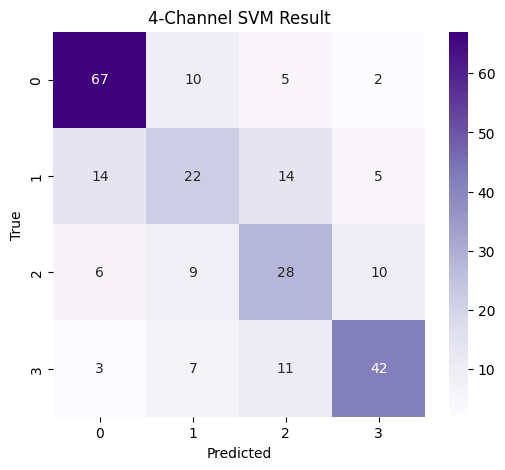

In [ ]:
# Step 4: 4채널 데이터 학습
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# [수정된 부분] feature_cols를 final_df에서 직접 추출 (에러 방지)
# 'label'과 'source_file'을 제외한 모든 컬럼을 특징으로 사용
feature_cols = [col for col in final_df.columns if col not in ['label', 'source_file']]

print(f"학습에 사용되는 특징({len(feature_cols)}개): {feature_cols}")

# 데이터 준비
X = final_df[feature_cols]
y = final_df['label']

# 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 모델 학습
print("🚀 4채널 모델 학습 시작...")
svm_model = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
svm_model.fit(X_train_scaled, y_train)

# 평가
y_pred = svm_model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)

print(f"\n🎯 4채널 통합 정확도: {acc*100:.2f}%")
print(classification_report(y_test, y_pred))

# 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Purples')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('4-Channel SVM Result')
plt.show()



4. test 데이터 classification 및 정확도 분석

🧪 테스트용 파일 발견: 2개
['sEMG_data_26.csv', 'sEMG_data_27.csv']

Analyzing: sEMG_data_26.csv...
🎯 정확도: 38.95%


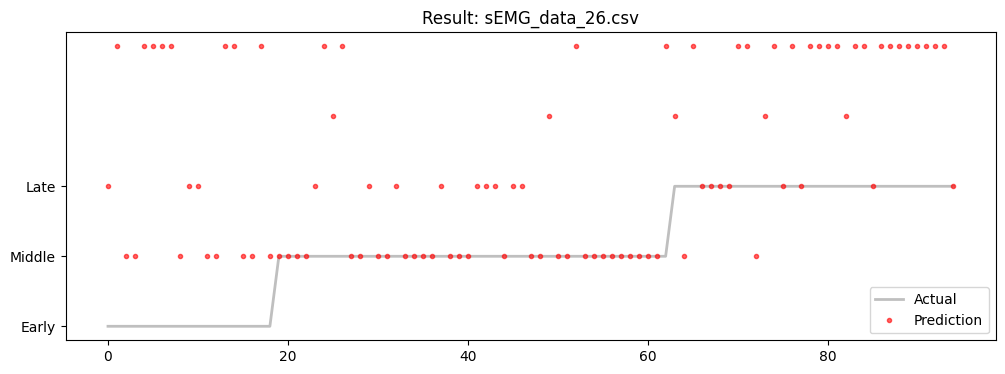


Analyzing: sEMG_data_27.csv...
🎯 정확도: 2.86%


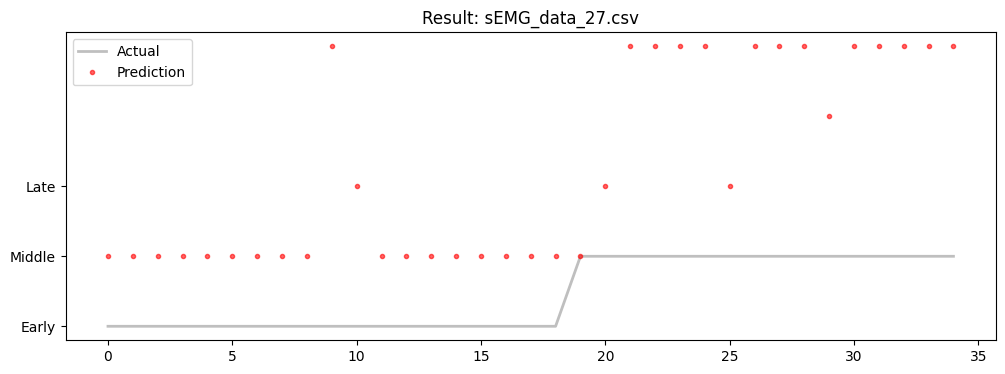

In [ ]:
# --- Step 5: 별도 경로의 테스트 파일 예측 ---

# 테스트용 파일이 있는 폴더 경로
test_folder_path = '/content/drive/MyDrive/Colab Notebooks/sEMG_data_test/'
test_file_pattern = test_folder_path + 'sEMG_data_*.csv'

test_files = glob.glob(test_file_pattern)
test_files.sort()

print(f"🧪 테스트용 파일 발견: {len(test_files)}개")
print([os.path.basename(f) for f in test_files])

# --- 테스트 실행 함수 ---
def test_and_plot(filename, model):
    print(f"\nAnalyzing: {os.path.basename(filename)}...")
    df = pd.read_csv(filename)
    raw_labels = df['label'].values

    # 1. 정규화 및 전처리
    normalized_channels = {}
    for ch in CHANNELS:
        raw_sig = df[ch].values.astype(float)
        scaler = MinMaxScaler()
        normalized_channels[ch] = scaler.fit_transform(raw_sig.reshape(-1, 1)).flatten()

    # 2. 특징 추출
    test_features = []
    test_true_labels = []

    data_len = len(normalized_channels['Ch1'])
    step = WINDOW_SIZE - OVERLAP_SIZE

    for i in range(0, data_len - WINDOW_SIZE + 1, step):
        # 라벨 처리 (3-Class)
        labels_in_window = raw_labels[i : i + WINDOW_SIZE]
        unique_labels = np.unique(labels_in_window)

        if len(unique_labels) == 1:
            label_origin = unique_labels[0]
            if label_origin == 5: continue

            if label_origin == 1: new_label = 0
            elif label_origin in [2, 3]: new_label = 1
            else: new_label = 2

            window_combined_features = []
            for ch in CHANNELS:
                window_data = normalized_channels[ch][i : i + WINDOW_SIZE]
                feats = extract_features_from_window(window_data, FS)
                window_combined_features.extend(feats)

            test_features.append(window_combined_features)
            test_true_labels.append(new_label)

    # 3. 예측 및 시각화
    if len(test_features) > 0:
        X_new = np.array(test_features)
        # 학습 때 썼던 scaler를 못 가져오므로 새로 fit (한계점이지만 시각화용으론 OK)
        scaler_new = StandardScaler()
        X_new_scaled = scaler_new.fit_transform(X_new)

        y_pred = model.predict(X_new_scaled)
        acc = accuracy_score(test_true_labels, y_pred)

        print(f"🎯 정확도: {acc*100:.2f}%")

        plt.figure(figsize=(12, 4))
        plt.plot(test_true_labels, label='Actual', color='gray', alpha=0.5, linewidth=2)
        plt.plot(y_pred, label='Prediction', color='red', marker='.', linestyle='None', alpha=0.6)
        plt.yticks([0, 1, 2], ['Early', 'Middle', 'Late'])
        plt.title(f'Result: {os.path.basename(filename)}')
        plt.legend()
        plt.show()
    else:
        print("데이터 부족으로 스킵")

# 모든 테스트 파일에 대해 실행
for f in test_files:
    test_and_plot(f, svm_model)




분석 중인 파일: sEMG_data_26.csv


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


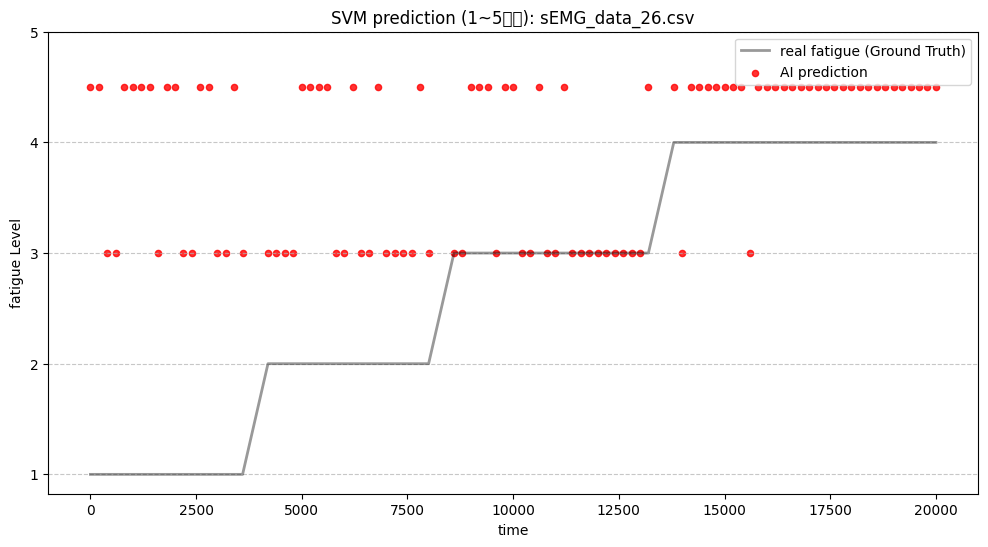


분석 중인 파일: sEMG_data_27.csv


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


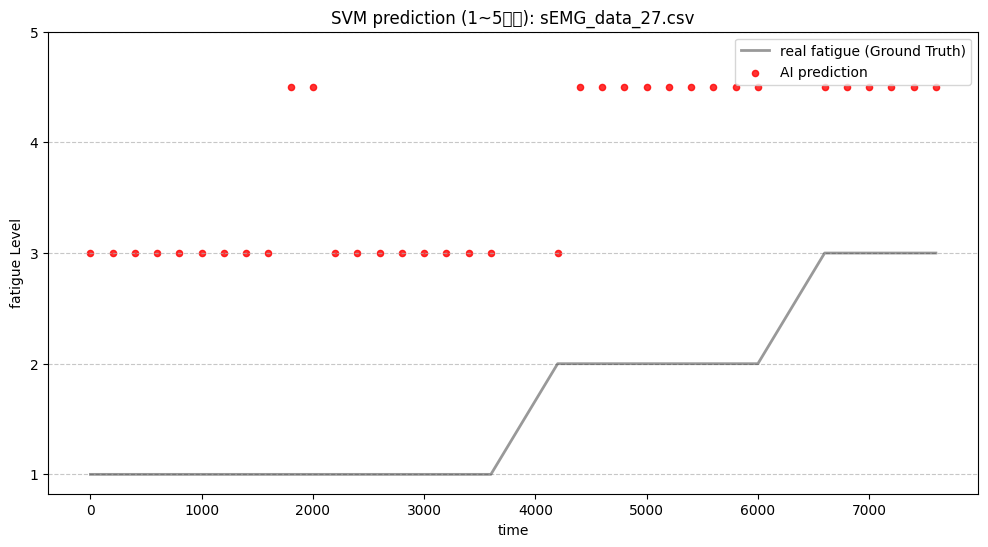

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 테스트 파일 경로
test_folder_path = '/content/drive/MyDrive/Colab Notebooks/sEMG_data_test/'
test_file_pattern = test_folder_path + 'sEMG_data_*.csv'
test_files.sort()

def test_and_plot_scale_1to5(filename, model):
    print(f"\n분석 중인 파일: {os.path.basename(filename)}")
    df = pd.read_csv(filename)
    raw_labels = df['label'].values # 1, 2, 3, 4, 5 그대로 사용

    # 1. 정규화
    normalized_channels = {}
    for ch in CHANNELS:
        raw_sig = df[ch].values.astype(float)
        scaler = MinMaxScaler()
        normalized_channels[ch] = scaler.fit_transform(raw_sig.reshape(-1, 1)).flatten()

    test_features = []
    original_true_labels = [] # 변환하지 않은 원래 라벨 (1~5)
    time_axis = []

    data_len = len(normalized_channels['Ch1'])
    step = WINDOW_SIZE - OVERLAP_SIZE

    for i in range(0, data_len - WINDOW_SIZE + 1, step):
        labels_in_window = raw_labels[i : i + WINDOW_SIZE]
        unique_labels = np.unique(labels_in_window)

        if len(unique_labels) == 1:
            label_origin = unique_labels[0]

            # 그래프 그릴 때는 5단계도 보여주고 싶으면 포함, 아니면 제외
            # 여기선 다 보여줍니다.

            window_combined_features = []
            for ch in CHANNELS:
                window_data = normalized_channels[ch][i : i + WINDOW_SIZE]
                feats = extract_features_from_window(window_data, FS)
                window_combined_features.extend(feats)

            test_features.append(window_combined_features)
            original_true_labels.append(label_origin) # 1,2,3,4,5 저장
            time_axis.append(i)

    # 2. 예측 및 매핑
    if len(test_features) > 0:
        X_new = np.array(test_features)
        scaler_new = StandardScaler()
        X_new_scaled = scaler_new.fit_transform(X_new)

        # 모델은 0, 1, 2로 예측함
        y_pred_class = model.predict(X_new_scaled)

        # [핵심] 0,1,2를 다시 1~5 스케일로 매핑 (시각화용)
        # 0(초기) -> 1.5 (1과 2 사이)
        # 1(중기) -> 3.0
        # 2(말기) -> 4.5 (4와 5 사이)
        y_pred_mapped = []
        for p in y_pred_class:
            if p == 0: y_pred_mapped.append(1.5)
            elif p == 1: y_pred_mapped.append(3.0)
            else: y_pred_mapped.append(4.5)

        # --- 그래프 그리기 ---
        plt.figure(figsize=(12, 6))

        # 실제값 (1~5단계) - 회색 실선
        plt.plot(time_axis, original_true_labels, label='real fatigue (Ground Truth)', color='black', linewidth=2, alpha=0.4)

        # 예측값 (매핑된 값) - 빨간 점
        plt.scatter(time_axis, y_pred_mapped, label='AI prediction', color='red', s=20, alpha=0.8)

        plt.yticks([1, 2, 3, 4, 5])
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.xlabel('time')
        plt.ylabel('fatigue Level')
        plt.title(f'SVM prediction (1~5단계): {os.path.basename(filename)}')
        plt.legend()
        plt.show()
    else:
        print("데이터 없음")

# 실행
for f in test_files:
    test_and_plot_scale_1to5(f, svm_model)




정확도가 매우 낮구만....